In [1]:
# Residual Network for batch effect correction
# See more at: https://github.com/ushaham/BatchEffectRemoval
# Hoa Tran
# Update code from python version 2 to python version 3, Keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import time
from datetime import timedelta
import scanpy as sc
from Calibration_Util import utils_resnet as utils     # our func
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4+18.gaabe446 anndata==0.6.17 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
# Create folder to save the results 
import os
dirname = os.getcwd()
print(dirname)
data_dir = '/acrc/jinmiao/CJM_lab/hoatran/demo_normalization/dataset/dataset10_hematoMNN_Hoa/final/'

if not os.path.exists('./results/'): os.makedirs('./results/')   
if not os.path.exists('./results/results_dataset10_hemato/'): os.makedirs('./results/results_dataset10_hemato/')    
save_dir = os.path.join(dirname, 'results/results_dataset10_hemato/')

# Function to save figure as image in the figures folder
save_fig_dir='./figures/dataset10_hemato/'
if not os.path.exists('./figures/'): os.makedirs('./figures/')
if not os.path.exists(save_fig_dir): os.makedirs(save_fig_dir)
def save_images(filename, save_fig_dir):    
    outname = save_fig_dir + filename + '.png'
    pl.savefig(outname, dpi=150)
    pl.close()

/acrc/jinmiao/CJM_lab/hoatran/demo_normalization/demo_ResNet/resnet


In [13]:

myDataFn1 = 'b1_exprs.txt'
mySampleFn1 = 'b1_celltype.txt'
batchid1 = 1
batchlb1 = 'batch1'
savefn1 = 'myRawData1.h5ad'
adata1 = utils.load_data(data_dir, myDataFn1, mySampleFn1, batchid1, batchlb1, save_dir, savefn1)

... storing 'cell_type' as categorical
... storing 'batchlb' as categorical


(3467, 2729)
Index(['W31107', 'W31108'], dtype='object')
Index(['ENSMUSG00000000290', 'ENSMUSG00000000594'], dtype='object')
(2729, 1)
Index(['CellType'], dtype='object')
Index(['W31107', 'W31108', 'W31109', 'W31110'], dtype='object', name='CellId')
AnnData object with n_obs × n_vars = 2729 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'


In [14]:
myDataFn2 = 'b2_exprs.txt'
mySampleFn2 = 'b2_celltype.txt'
batchid2 = 2
batchlb2 = 'batch2'
savefn2 = 'myRawData2.h5ad'
adata2 = utils.load_data(data_dir, myDataFn2, mySampleFn2, batchid2, batchlb2, save_dir, savefn2)

... storing 'cell_type' as categorical
... storing 'batchlb' as categorical


(3467, 1920)
Index(['HSPC_013', 'HSPC_019'], dtype='object')
Index(['ENSMUSG00000000290', 'ENSMUSG00000000594'], dtype='object')
(1920, 1)
Index(['CellType'], dtype='object')
Index(['HSPC_013', 'HSPC_019', 'HSPC_025', 'HSPC_031'], dtype='object', name='CellId')
AnnData object with n_obs × n_vars = 1920 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'


In [15]:
sum(adata2.var_names==adata1.var_names)

3467

In [16]:
# Combine 2 dataframe to run PCA
# adata = sc.AnnData(adata1, adata2, batch_key='batch')
# adata
adata = sc.AnnData(np.concatenate([adata1.X, adata2.X]))
adata.obs_names = adata1.obs_names.tolist() + adata2.obs_names.tolist()
adata.var_names = adata1.var_names.tolist()
adata.obs['cell_type'] = adata1.obs['cell_type'].tolist() + adata2.obs['cell_type'].tolist()
adata.obs['batch'] = adata1.obs['batch'].tolist() + adata2.obs['batch'].tolist()
adata.obs['batchlb'] = adata1.obs['batchlb'].tolist() + adata2.obs['batchlb'].tolist()
adata

AnnData object with n_obs × n_vars = 4649 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'

In [17]:
# Ignore this step for this dataset
# Filtering data 
# sc.pp.filter_cells(adata, min_genes=300)
# sc.pp.filter_genes(adata, min_cells=10)
# adata

In [18]:
# Here authors extract 50 pca vectors to train the network model
npcs_train = 50  
sc.tl.pca(adata, svd_solver='arpack', n_comps=npcs_train)  # output save to adata.obsm['X_pca']

# Raw data
npcs = 20  # our pre-defined
perplex = 30  # our pre-defined
sc.pp.neighbors(adata,n_neighbors=15, n_pcs=npcs)
sc.tl.tsne(adata, random_state=0, n_pcs=npcs, perplexity=perplex)
sc.tl.umap(adata)
color_group = ["batch","cell_type"]
sc.pl.tsne(adata, color = color_group, show=False, wspace=.3)
save_images('resnet_tsne_raw',save_fig_dir) 

sc.pl.umap(adata, color = color_group, show=False)
save_images('resnet_umap_raw',save_fig_dir)
adata

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:07.87) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 20
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:26.42) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP


... storing 'cell_type' as categorical
... storing 'batchlb' as categorical


    finished (0:00:16.53) --> added
    'X_umap', UMAP coordinates (adata.obsm)


AnnData object with n_obs × n_vars = 4649 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'
    uns: 'pca', 'neighbors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [19]:
# Extract data from batch 1 and batch 2
adata1_filtered = adata[adata.obs['batch']==1,:].copy()  # after concatenate, the values change from 1 to 0, 2 to 1
print(adata1_filtered)
adata2_filtered = adata[adata.obs['batch']==2,:].copy()
print(adata2_filtered)
adata1_filtered.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, as suggestion from Scanpy
adata2_filtered.obsm['X_pca'] *= -1 # multiply by -1 to match Seurat, as suggestion from Scanpy
print(adata2_filtered.obsm['X_pca'].shape[1])

AnnData object with n_obs × n_vars = 2729 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'
    uns: 'pca', 'neighbors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 1920 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'
    uns: 'pca', 'neighbors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
50


In [20]:
import keras.optimizers
from keras.layers import Input, Dense, merge, BatchNormalization, Activation
from keras.models import Model
from keras import callbacks as cb
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
import math
from keras import backend as K
import sklearn.preprocessing as prep
from sklearn import decomposition
from statsmodels.distributions.empirical_distribution import ECDF
from keras import initializers
from keras.layers import add
from Calibration_Util import CostFunctions as cf  # MMD-ResNet author func
from Calibration_Util import Monitoring as mn     # author func



Using TensorFlow backend.


Create a training model: 
setting scales using KNN
[3223.8045273138077, 6447.6090546276155, 12895.218109255231]
setting all scale weights to 1


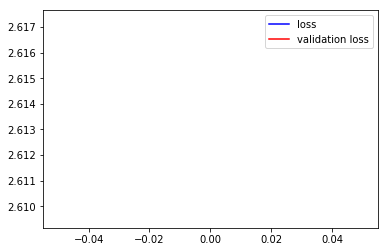

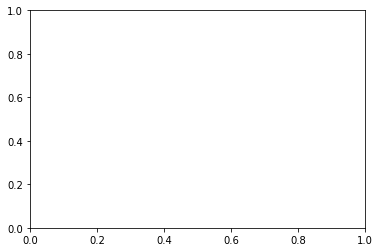

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

(2729, 50)
Took 0:14:13.137202


In [31]:
target = adata2_filtered.obsm['X_pca']
source = adata1_filtered.obsm['X_pca']
space_dim = 50
batch_size = 50
penalty = 1e-2
nbeps = 30
val_split = 0.1
savedfl = 'resnet_d10_target2_source1'
t1 = time.time()
calibMMDNet,block2_output = utils.createMMDResNetModel(target, source, space_dim, batch_size, penalty, save_dir, nbeps, val_split, savedfl)
afterCalib = calibMMDNet.predict(source)   # align, calibrate source data to target data
print(afterCalib.shape)
t2 = time.time()
print('Took '+str(timedelta(seconds=t2-t1)))

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# Plot distribution, see the change after train and predict source data, compared to target data
# from Calibration_Util import ScatterDemo as sd

save_file_bf = os.path.join(save_fig_dir,'d10_distribution_before.png')
save_file_af = os.path.join(save_fig_dir, 'd10_distribution_after.png')
# The PCs most correlated with the batch are {1 and 2} or {3 and 5}
pc1 = 1
pc2 = 2
utils.myScatterHistDemo(target[:,pc1], target[:,pc2], source[:,pc1], source[:,pc2],save_file_bf)
utils.myScatterHistDemo(target[:,pc1], target[:,pc2], afterCalib[:,pc1], afterCalib[:,pc2],save_file_af)

In [33]:
## quantitative evaluation: MMD ###
# MMD with the scales used for training 
# Compute Maximum Mean Discrepancy Distance 
# between source data- before correction, source data-after correction, target data and Ground Truth - filter data, one layer in network 
# If MMD distance is smaller --> 2 distributions are shift closer, less of batch effect 
# If MMD distance is not many different --> this method can not remove batch effect
sourceInds = np.random.randint(low=0, high = source.shape[0], size = 1000)
targetInds = np.random.randint(low=0, high = target.shape[0], size = 1000)
mmd_before = K.eval(cf.MMD(block2_output,target).cost(K.variable(value=source[sourceInds]), K.variable(value=target[targetInds])))
mmd_after = K.eval(cf.MMD(block2_output,target).cost(K.variable(value=afterCalib[sourceInds]), K.variable(value=target[targetInds])))
print('MMD before calibration: ' + str(mmd_before))
print('MMD after calibration: ' + str(mmd_after))

setting scales using KNN
[3250.4217339564966, 6500.843467912993, 13001.686935825986]
setting all scale weights to 1
setting scales using KNN
[3214.2654402514927, 6428.530880502985, 12857.06176100597]
setting all scale weights to 1
MMD before calibration: 2.6519465
MMD after calibration: 2.6554613


In [34]:
print(target.shape)  
print(afterCalib.shape) 
adata1_filtered.obsm['X_pca'] = afterCalib
adata2_filtered.obsm['X_pca'] = target
pca_corrected = np.concatenate([afterCalib,target])
adata.obsm['X_pca'] = pca_corrected
npcs = 20  # our pre-defined
perplex = 30  # our pre-defined
sc.pp.neighbors(adata,n_neighbors=15, n_pcs=npcs)
sc.tl.tsne(adata, random_state=0, n_pcs=npcs, perplexity=perplex)
sc.tl.umap(adata)
print(adata)
color_group = ["batch","cell_type"]
sc.pl.tsne(adata, color = color_group, show=False, wspace=.3)
save_images('resnet_tsne_corrected_target2_source1',save_fig_dir) 

sc.pl.umap(adata, color = color_group, show=False)
save_images('resnet_umap_corrected_target2_source1',save_fig_dir)

(1920, 50)
(2729, 50)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:05.91) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 20
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:41.09) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP
    finished (0:00:17.62) --> added
    'X_umap', UMAP coordinates (adata.obsm)
AnnData object with n_obs × n_vars = 4649 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'
    uns: 'pca', 'neighbors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'


In [ ]:
print(save_dir)
adata.write_h5ad(os.path.join(save_dir,'resnet_pca_corrected.h5ad'))

In [29]:
# Save output of umap for visualization
import pandas as pd
print(adata)
# pca_corrected
utils.save_output_txt(adata, save_dir)

AnnData object with n_obs × n_vars = 4649 × 3467 
    obs: 'cell_type', 'batch', 'batchlb'
    uns: 'pca', 'neighbors', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'


In [30]:
# Save execution time to file for evaluation
# Evaluation runtime of main batch effect removal function
filename = 'resnet_exetime.csv'
usecase_name = 'resnet_exetime' 
utils.getExecutionTime(t1, t2, save_dir, usecase_name, filename)  # t1: start time, t2: end time       

Took seconds: 0:04:48
Took minutes: (4.0, 48.28839945793152)
Took hours_minutes_seconds:  0.0 4.0 48.28839945793152
               use_case exetime_secs exetimehours exetimemins exetimesecs
exetime  resnet_exetime          288          0.0         4.0          48
